In [1]:
from itertools import islice

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import pandas as pd
from sklearn.manifold import TSNE

In [3]:
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from pytorch_lightning.loggers import CSVLogger
from datasets import load_dataset

from estimator import TorchscaleEstimator

2022-11-28 23:54:59.228194: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
dataset = get_dataset("electricity")

In [15]:
enc_dec_config = dict(
    encoder_attention_heads=2,
    decoder_attention_heads=2,
    encoder_layers=6,
    decoder_layers=2,
    encoder_ffn_embed_dim=32,
    decoder_ffn_embed_dim=32,
    deepnorm=True,
)

In [16]:
estimator = TorchscaleEstimator(
        freq=dataset.metadata.freq,
        prediction_length=dataset.metadata.prediction_length,
        context_length=dataset.metadata.prediction_length*6,
        
        scaling=True,
        num_feat_static_cat=len(dataset.metadata.feat_static_cat),
        cardinality=[int(cat_feat_info.cardinality) for cat_feat_info in dataset.metadata.feat_static_cat],
        embedding_dimension=[5],
        
        enc_dec_config=enc_dec_config,
        
        batch_size=256,
        num_batches_per_epoch=100,
        trainer_kwargs=dict(accelerator='gpu', devices='1', max_epochs=50, logger=CSVLogger(".", "lightning_logs/")),
    )

In [17]:
predictor = estimator.train(
        training_data=dataset.train,
        shuffle_buffer_length=1024,
        num_workers=8,
        cache_data=True,
    )

/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params
------------------------------------------
0 | model | TorchscaleModel | 141 K 
------------------------------------------
141 K     Trainable params
0         Non-trainable params
141 K     Total params
0.565     Total estimate

Training: 0it [00:00, ?it/s]

Epoch 0, global step 100: 'train_loss' reached 6.19118 (best 6.19118), saving model to './lightning_logs/version_22/checkpoints/epoch=0-step=100.ckpt' as top 1
Epoch 1, global step 200: 'train_loss' reached 5.53603 (best 5.53603), saving model to './lightning_logs/version_22/checkpoints/epoch=1-step=200.ckpt' as top 1
Epoch 2, global step 300: 'train_loss' reached 5.41167 (best 5.41167), saving model to './lightning_logs/version_22/checkpoints/epoch=2-step=300.ckpt' as top 1
Epoch 3, global step 400: 'train_loss' reached 5.34164 (best 5.34164), saving model to './lightning_logs/version_22/checkpoints/epoch=3-step=400.ckpt' as top 1
Epoch 4, global step 500: 'train_loss' reached 5.27280 (best 5.27280), saving model to './lightning_logs/version_22/checkpoints/epoch=4-step=500.ckpt' as top 1
Epoch 5, global step 600: 'train_loss' reached 5.23810 (best 5.23810), saving model to './lightning_logs/version_22/checkpoints/epoch=5-step=600.ckpt' as top 1
Epoch 6, global step 700: 'train_loss' r

In [18]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor,
)

In [19]:
forecasts = list(forecast_it)

In [10]:
tss = list(ts_it)

In [20]:
evaluator = Evaluator()

In [21]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 2247it [00:00, 2573.54it/s]
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pandas/core/dtypes/astype.py:170: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [22]:
agg_metrics

{'MSE': 2539395.386475215,
 'abs_error': 11997401.98090744,
 'abs_target_sum': 128632956.0,
 'abs_target_mean': 2385.272140631954,
 'seasonal_error': 189.49338196116761,
 'MASE': 0.9517694268374104,
 'MAPE': 0.113209351550685,
 'sMAPE': 0.12089808357133741,
 'MSIS': 8.033074072588281,
 'QuantileLoss[0.1]': 5383996.103385585,
 'Coverage[0.1]': 0.2306593977154725,
 'QuantileLoss[0.2]': 8412028.65173243,
 'Coverage[0.2]': 0.4034824210057855,
 'QuantileLoss[0.3]': 10396657.407125933,
 'Coverage[0.3]': 0.5377725856697819,
 'QuantileLoss[0.4]': 11584928.473029224,
 'Coverage[0.4]': 0.6508678237650201,
 'QuantileLoss[0.5]': 11997401.97073013,
 'Coverage[0.5]': 0.7414144785640112,
 'QuantileLoss[0.6]': 11501831.512725353,
 'Coverage[0.6]': 0.8104138851802403,
 'QuantileLoss[0.7]': 10523039.623305868,
 'Coverage[0.7]': 0.8740542946150422,
 'QuantileLoss[0.8]': 8916500.688121634,
 'Coverage[0.8]': 0.9259939178163478,
 'QuantileLoss[0.9]': 6169525.347754505,
 'Coverage[0.9]': 0.966381100726895,
 

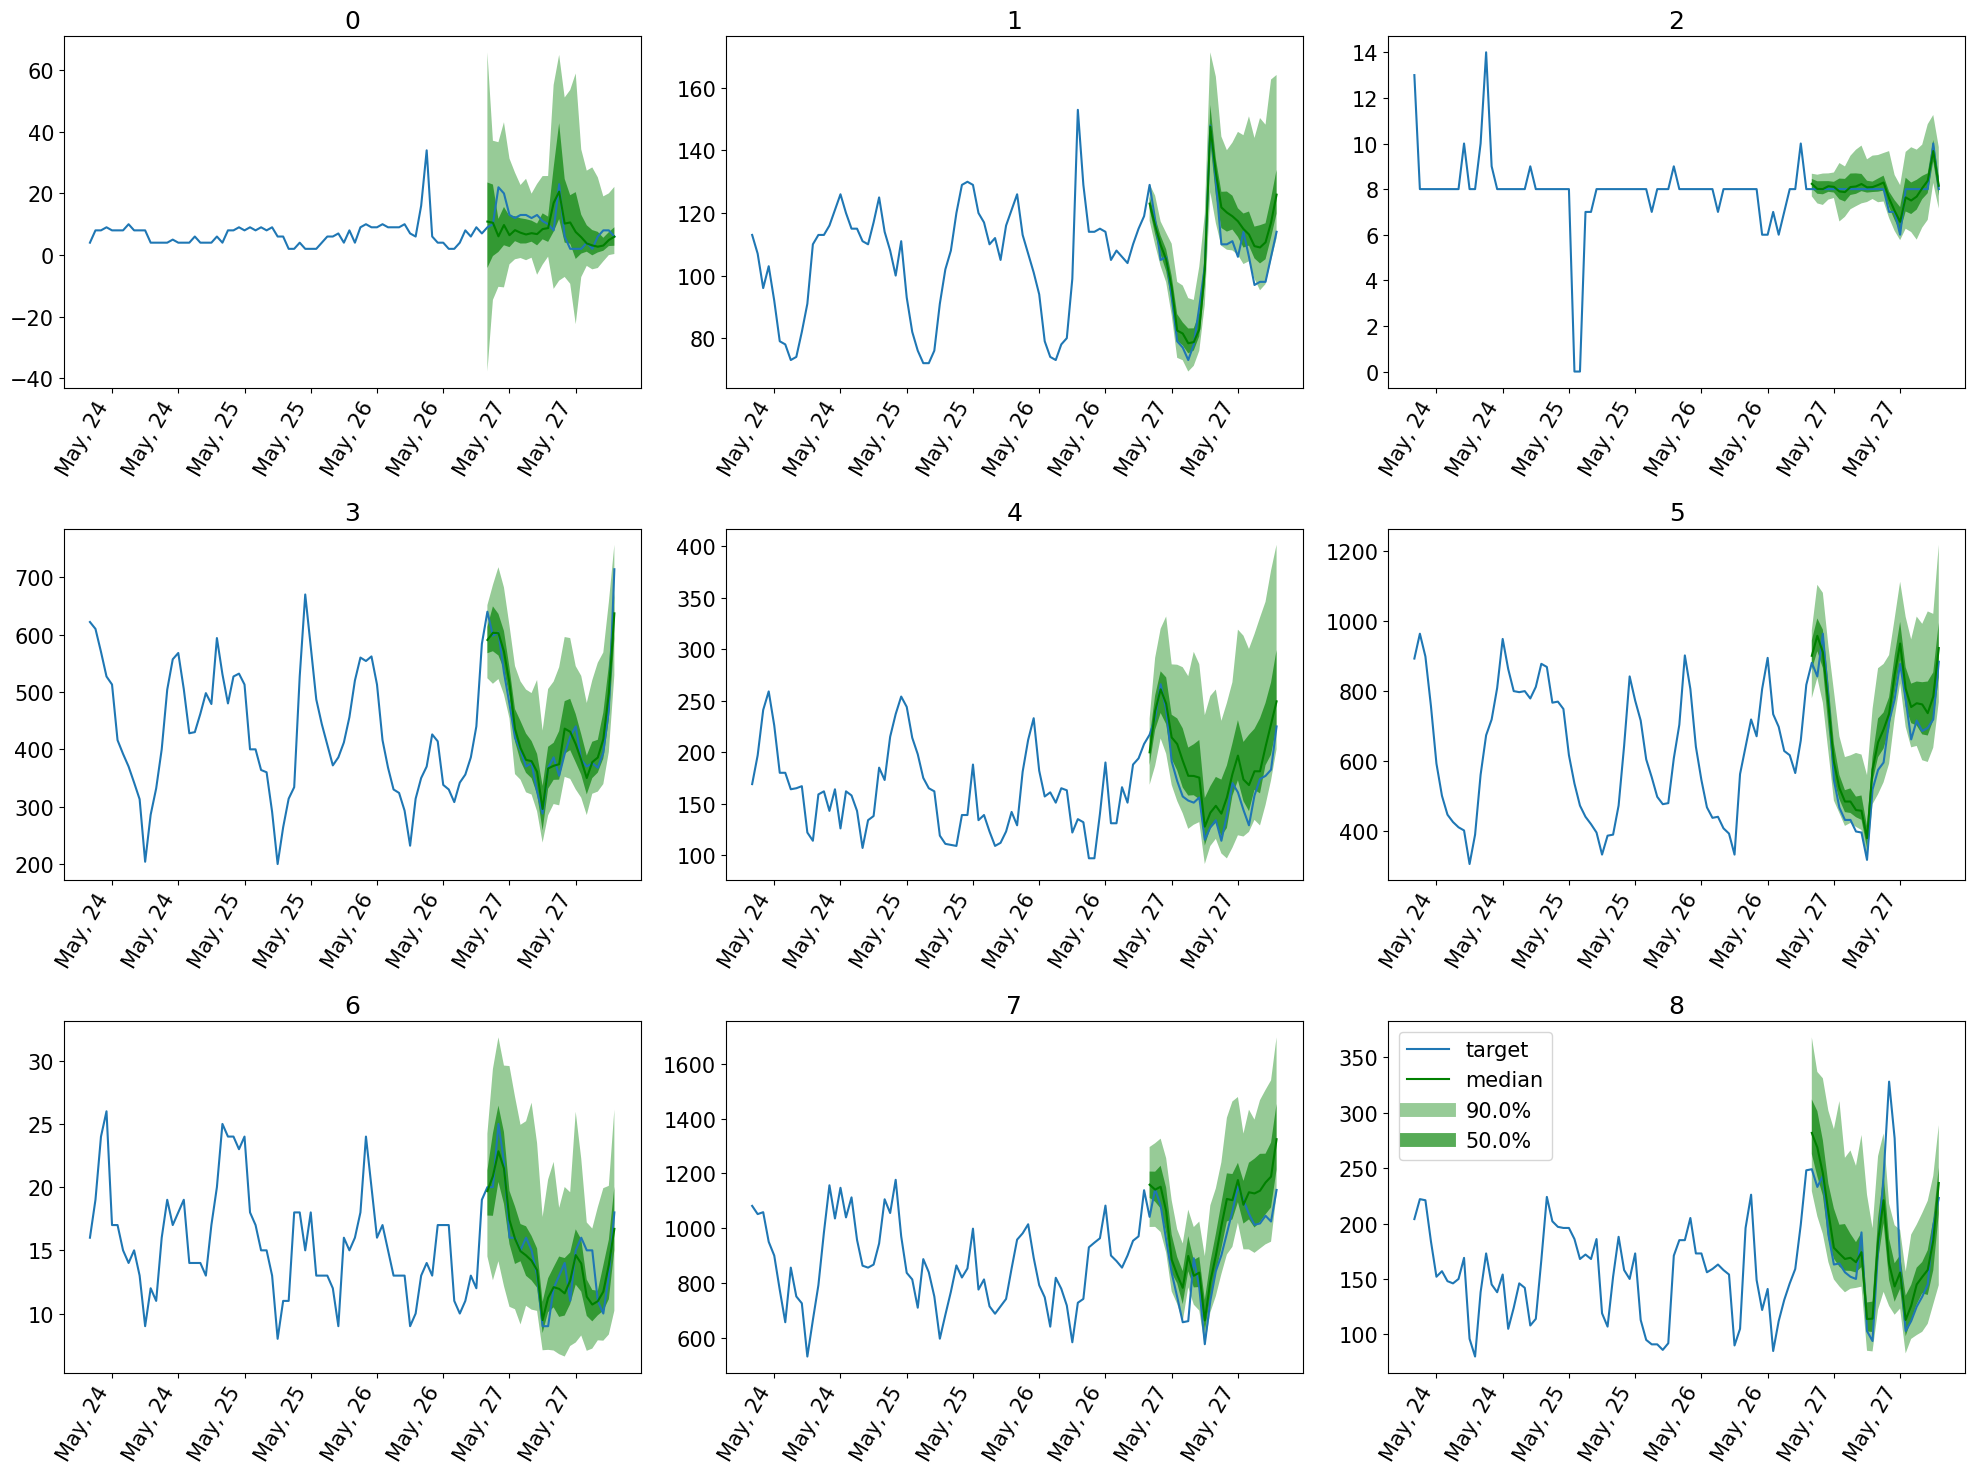

In [23]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [18]:
metrics = pd.read_csv("lightning_logs/version_86/metrics.csv")

In [19]:
metrics

,train_perplexity,epoch,step,val_loss,train_loss
0,2.042362,0,49,NaN,NaN
1,2.050069,0,99,NaN,NaN
2,2.743227,0,149,NaN,NaN
3,2.440984,0,199,NaN,NaN
4,NaN,0,199,4.355846,NaN
...,...,...,...,...,...
295,80.659866,49,9899,NaN,NaN
296,82.568138,49,9949,NaN,NaN
297,81.211136,49,9999,NaN,NaN
298,NaN,49,9999,1.084462,NaN


Text(0, 0.5, 'perplexity')

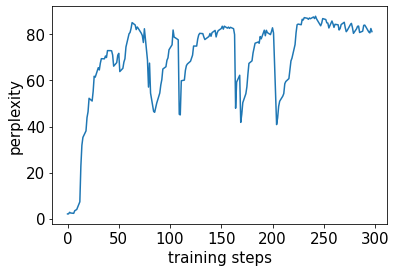

In [20]:
ax = metrics.train_perplexity.dropna().plot(kind="line")
ax.set_xlabel("training steps")
ax.set_ylabel("perplexity")

Text(0, 0.5, 'val neg. log likelihood')

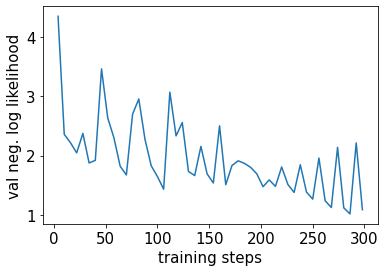

In [21]:
ax = metrics.val_loss.dropna().plot()
ax.set_xlabel("training steps")
ax.set_ylabel("val neg. log likelihood")

In [22]:
X = predictor.prediction_net.vq_vae.embed.cpu()

In [23]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)

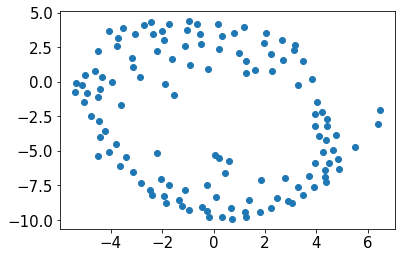

In [24]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], alpha=1.0)